In [13]:
from __future__ import print_function
import os
data_path = ['..', '..', 'data']

In [14]:
import pandas as pd
import numpy as np

# Import the data using the file path
data = pd.read_csv("Human_Resources_Employee_Attrition.csv")

print(data.shape)

(14999, 10)


In [15]:
data.dtypes.value_counts()

int64      6
object     2
float64    2
dtype: int64

In [16]:
# Select the object (string) columns
mask = data.dtypes == np.object
categorical_cols = data.columns[mask]

In [17]:
# Determine how many extra columns would be created
num_ohc_cols = (data[categorical_cols]
                .apply(lambda x: x.nunique())
                .sort_values(ascending=False))


# No need to encode if there is only one value
small_num_ohc_cols = num_ohc_cols.loc[num_ohc_cols>1]

# Number of one-hot columns is one less than the number of categories
small_num_ohc_cols -= 1

# This is 215 columns, assuming the original ones are dropped. 
# This is quite a few extra columns!
small_num_ohc_cols.sum()
print(small_num_ohc_cols.sum())

11


In [78]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Copy of the data
data_ohc = data.copy()

# The encoders
le = LabelEncoder()


le.fit(data_ohc["salary"])
list(le.classes_)
dat1 = le.transform(data_ohc["salary"])

le.fit(data_ohc["department"])
list(le.classes_)
dat2 =le.transform(data_ohc["department"])


data_ohc = data_ohc.drop("salary", axis=1)
data_ohc = data_ohc.drop("department", axis=1)

data_ohc["department"] = dat2
data_ohc["salary"] = dat1

    

In [87]:
from sklearn.model_selection import train_test_split

# Split the data that is not one-hot encoded
feature_cols = [x for x in data_ohc.columns if x != "satisfaction_level"]
X_data = data_ohc[feature_cols]
y_data = data_ohc["satisfaction_level"]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.1, random_state=321)


In [88]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

LR = LinearRegression()

# Storage for error values
error_df = list()

# Data that have not been one-hot encoded
LR = LR.fit(X_train, y_train)
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)

error_df.append(pd.Series({'train': mean_squared_error(y_train, y_train_pred),
                           'test' : mean_squared_error(y_test,  y_test_pred)},
                           name='no enc'))

# Assemble the results
error_df = pd.concat(error_df, axis=1)
error_df

,no enc
train,0.051855
test,0.051006


In [89]:
# Mute the setting wtih a copy warnings
pd.options.mode.chained_assignment = None

In [90]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler


scalers = {'standard': StandardScaler(),
           'minmax': MinMaxScaler(),
           'maxabs': MaxAbsScaler()}

training_test_sets = {
    'not_encoded': (X_train, y_train, X_test, y_test)}


# Get the list of float columns, and the float data
# so that we don't scale something we already scaled. 
# We're supposed to scale the original data each time
mask = X_train.dtypes == np.float
float_columns = X_train.columns[mask]

# initialize model
LR = LinearRegression()

# iterate over all possible combinations and get the errors
errors = {}
for encoding_label, (_X_train, _y_train, _X_test, _y_test) in training_test_sets.items():
    for scaler_label, scaler in scalers.items():
        trainingset = _X_train.copy()  # copy because we dont want to scale this more than once.
        testset = _X_test.copy()
        trainingset[float_columns] = scaler.fit_transform(trainingset[float_columns])
        testset[float_columns] = scaler.transform(testset[float_columns])
        LR.fit(trainingset, _y_train)
        predictions = LR.predict(testset)
        key = encoding_label + ' - ' + scaler_label + 'scaling'
        errors[key] = mean_squared_error(_y_test, predictions)

errors = pd.Series(errors)
print(errors.to_string())
print('-' * 80)
for key, error_val in errors.items():
    print(key, error_val)

not_encoded - standardscaling    0.051006
not_encoded - minmaxscaling      0.051006
not_encoded - maxabsscaling      0.051006
--------------------------------------------------------------------------------
not_encoded - standardscaling 0.05100582736481681
not_encoded - minmaxscaling 0.05100582736481681
not_encoded - maxabsscaling 0.05100582736481681


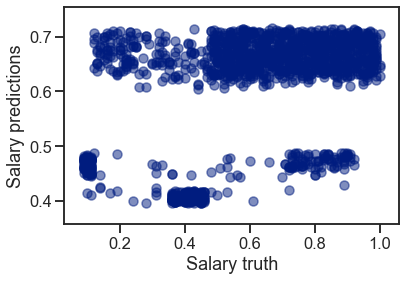

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(y_test, y_test_pred, alpha=.5)

ax.set(xlabel='Salary truth', 
       ylabel='Salary predictions',
       title='');